# Lensless Dataset Tutorial
This Jupyter notebook contains a tutorial for using the dataset from the [Parallel Lensless Dataset project](https://waller-lab.github.io/parallel-lensless-dataset/). All data can be found in and downloaded from [this folder](https://drive.google.com/drive/folders/1tY0lgakSKO-ztF5A_ulVPBQDTz4eh7T5?usp=drive_link). This notebook provides guidance using 8x downsampled and undistorted ground truth measurements that are warped to each lensless imager's coordinate spaces.

Acronyms:
- Ground Truth (GT)
- Random Multi-Focal Lenslet (RML)
- Diffusercam (DC)
- Field-of-View (FOV)

This notebook assumes that filenames are not changed within the downloaded data directory structure, and that all files are in a root directory. Please update the root directory path below:

In [ ]:
ROOT_DIR = '/home/lakabuli/cosmos_drive/' # TODO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import rescale, resize
import torch
import kornia.geometry.transform as transform

/home/clara/.local/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## 1. Processing ground truth measurements
We have prepared [a folder](https://drive.google.com/drive/folders/1D8frfCtFoi3REklvPk--Tl55SCADH4PH?usp=drive_link) with pre-processed ground truth measurements. Starting with the full-resolution (1200, 1920) measurements, these measurements have been undistorted to correct for lens distortion, downsampled by a factor of 8 to form (150, 240) measurements, and warped to the space of each respective lensless imager.

This section performs the following operations:
- loads a single ground truth image from the dataset with shape (150, 240, 4)
- removes the alpha channel associated with `matplotlib.imread`

Download and unzip the files:
- [GT to RML](https://drive.google.com/file/d/17ssGgNLTj8EKtvJozh3lO1hojNNJabK7/view?usp=sharing)
- [GT to DC](https://drive.google.com/file/d/1HqKzfOOCtxrWYf0If1sK56EVVTrwMGxw/view?usp=sharing)

Image shape:  (150, 240, 4)
Cropped shape:  (102, 102, 4)


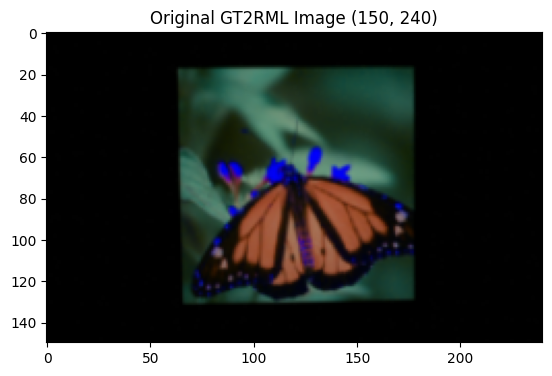

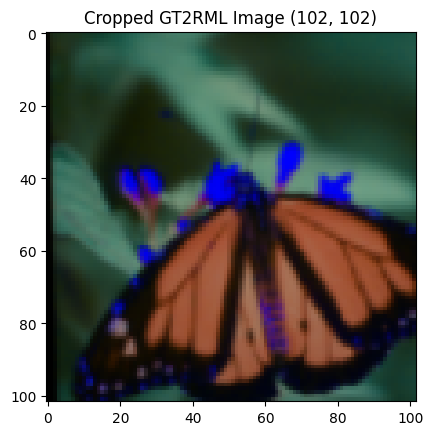

In [ ]:
## Ground Truth to RML
object_idx = 64
gt2RML_image_path = os.path.join(ROOT_DIR, 'undistorted_GT2RML', 'warped_undistorted_img_{}_cam_2.tiff'.format(object_idx))
gt2RML_image = plt.imread(gt2RML_image_path)
print("Image shape: ", gt2RML_image.shape) # verify that shape is (150, 240, 4)

plt.figure()
plt.title("Original GT2RML Image (150, 240)")
plt.imshow(gt2RML_image)

Image shape:  (150, 240, 4)
Cropped shape:  (102, 102, 4)


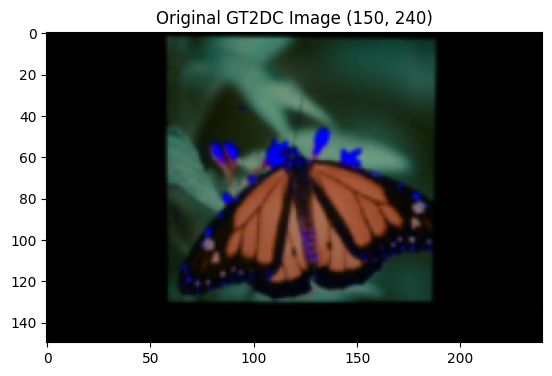

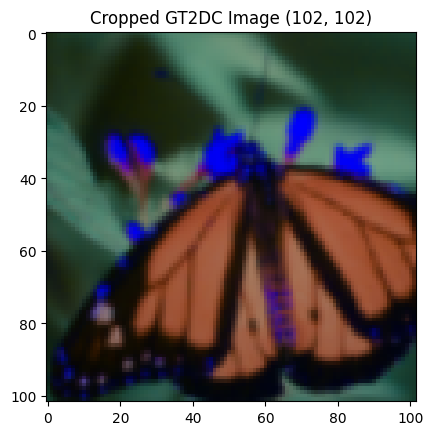

In [ ]:
## Ground Truth to Diffusercam
object_idx = 64
gt2DC_image_path = os.path.join(ROOT_DIR, 'undistorted_GT2DC', 'warped_undistorted_img_{}_cam_2.tiff'.format(object_idx))
gt2DC_image = plt.imread(gt2DC_image_path)
print("Image shape: ", gt2DC_image.shape) # verify that shape is (150, 240, 4)

plt.figure()
plt.title("Original GT2DC Image (150, 240)")
plt.imshow(gt2DC_image)

## 2. Processing lensless imager measurements
Lensless imager measurements need to be 8x downsampled to match the undistorted ground truth resolution: (1200, 1920) -> (150, 240)

Download and unzip the files:
- [Full resolution RML measurements](https://drive.google.com/file/d/16teCy-uPhz_NhC7DCmIbDiWkcVEZffV1/view?usp=sharing)
- [Full resolution DC measurements](https://drive.google.com/file/d/10ODJ6n4sPufdOS1yr6KdjjjsMKZjnQqs/view?usp=sharing)

Image shape:  (1200, 1920, 3)
Resized shape:  (1200, 1920, 3)


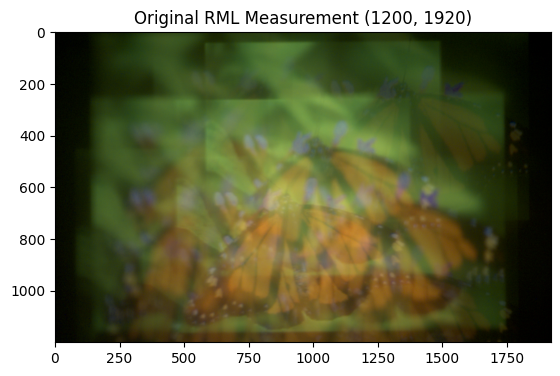

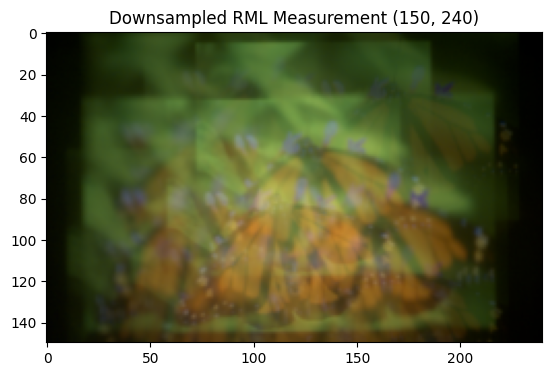

In [12]:
# Downsampling RML measurements
object_idx = 64
RML_image_path = os.path.join(ROOT_DIR, '0-25k/rml', 'img_{}_cam_1.tiff'.format(object_idx))
RML_image = plt.imread(RML_image_path)
print("Image shape: ", RML_image.shape) # verify that shape is (1200, 1920, 3)
ds_RML_image = resize(RML_image, (150, 240), anti_aliasing=True).astype(np.float32) # resize to 150 x 240
print("Resized shape: ", RML_image.shape)

plt.figure()
plt.title("Original RML Measurement (1200, 1920)")
plt.imshow(RML_image)

plt.figure()
plt.title("Downsampled RML Measurement (150, 240)")
plt.imshow(ds_RML_image)

Image shape:  (1200, 1920, 3)
Resized shape:  (1200, 1920, 3)


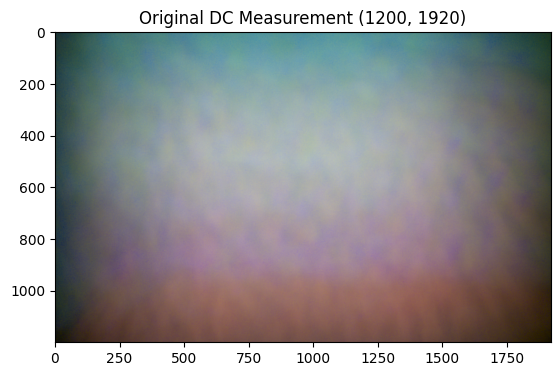

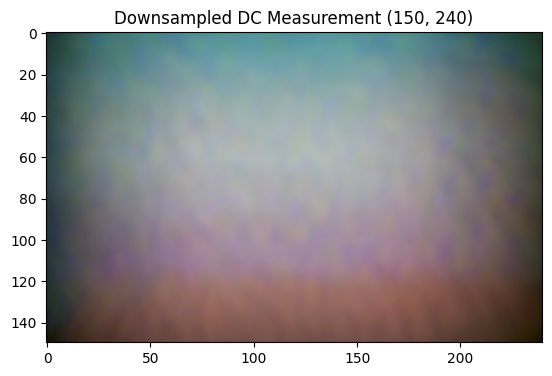

In [13]:
## Downsampling DC measurements
object_idx = 64
DC_image_path = os.path.join(ROOT_DIR, '0-25k/diffusercam', 'img_{}_cam_0.tiff'.format(object_idx))
DC_image = plt.imread(DC_image_path)
print("Image shape: ", DC_image.shape) # verify that shape is (1200, 1920, 3)
ds_DC_image = resize(DC_image, (150, 240), anti_aliasing=True).astype(np.float32) # resize to 150 x 240
print("Resized shape: ", DC_image.shape)

plt.figure()
plt.title("Original DC Measurement (1200, 1920)")
plt.imshow(DC_image)

plt.figure()
plt.title("Downsampled DC Measurement (150, 240)")
plt.imshow(ds_DC_image)

## 3. Preprocessing for training
Once ground truth and lensless measurements have been loaded and processed, preprocessing may be necessary for training image reconstructions. For our image reconstruction algorithms in Pytorch, images are preprocessed as follows:
- Ensure images are 3 channels
- convert from uint8 to float32
- resize image to correct downsampling level (may be redundant but is a good check). We use 8x downsampling (150, 240) but change this based on your downsampling level if you are using other data
- normalize to 0 - 1 and clip image to 0-1
- convert to a torch tensor
- reshape to have channel dimension first (H, W, C) -> (C, H, W)

In this example, we use an RML image to illustrate the process.

In [ ]:
image = ds_RML_image
target = gt2RML_image
downsampled_dims = (150, 240)

In [ ]:
# if images include alpha channel, remove
if image.shape[-1] == 4:
    image = image[..., :-1]
if target.shape[-1] == 4:
    target = target[..., :-1]

# convert images to 0 to 1 range and convert to float, they're 8 bit 0 - 255 otherwise 
image = (image / 255.0).astype(np.float32)
target = (target / 255.0).astype(np.float32) 

# resize measurement 
image = resize(image, downsampled_dims, anti_aliasing=True).astype(np.float32)
assert image.shape == target.shape 

# clip 0-1
image = np.clip(image, 0,1)
target = np.clip(target, 0, 1)

image = torch.from_numpy(image)
target = torch.from_numpy(target)

# Move channels to the front
image = torch.moveaxis(image, -1, 0)
target = torch.moveaxis(target, -1, 0)

## 4. Cropping for training loss

In training, you may want to crop out the black borders before loss evaluation. Since these reconstructions are done in each lensless imager's space, there is a different cropping FOV necessary. Below, we use examples of the crop regions we use for both RML and Diffusercam for (150, 240) reconstructions. 
We use the ground truth image in this example but you should replace the image with recons for each respective imager.

#### RML

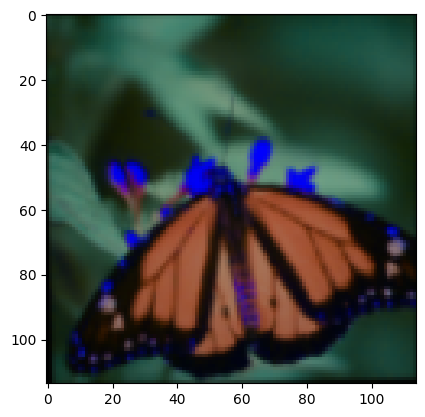

In [ ]:
# load rml recons 
rml_recon = gt2RML_image # placeholder, replace with your recon
cropped_image = rml_recon[17:131, 64:178]
plt.imshow(cropped_image)

#### Diffusercam

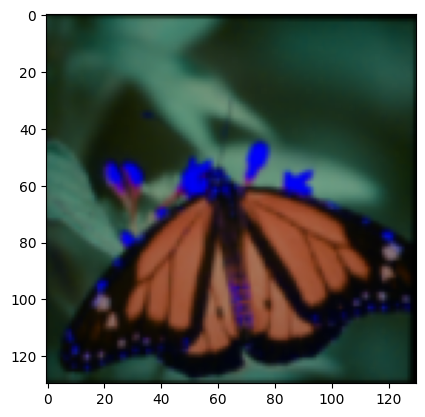

In [18]:
# load dc recons 
dc_recon = gt2DC_image # placeholder, replace with your recon
cropped_image = dc_recon[1:131, 59:189]
plt.imshow(cropped_image)

## 5. Evaluation view
In order to compare the three imagers (GT, DC, RML) in the same imaging space, we can warp both lensless imagers to the space of the ground truth camera and crop accordingly. To do this, we use a calibrated homography matrix and the Kornia package. We assume a single image, or batch size of 1, in this example.

Download [both homography transform files here.](https://drive.google.com/drive/folders/19V4PdGSHDkb-5Dsu--KWWgOh2WOe7Rs4?usp=drive_link)

Path to homography and load homography:

In [ ]:
rml_homog_path = os.path.join(ROOT_DIR, 'RML_homographies') #Lensless2GroundTruth
rml_homography = torch.load(os.path.join(rml_homog_path, 'RML2GT_homography_x8_color_detached.npy'))

Load recons and apply homography

In [ ]:
# recons need to be in b x c x h x w format 
rml_recon_path = '/home/lakabuli/workspace/EncodingInformation/lensless_imager/ICCP_2025/experimental_mi/uncropped_inference_images_rml.npy'
rml_recon = np.load(rml_recon_path)
rml_recon_tensor = torch.from_numpy(rml_recon) 
rml_recon_tensor = transform.warp_perspective(rml_recon_tensor, rml_homography, dsize=(150, 240), align_corners=True)
cropped_rml_recon = rml_recon_tensor[25:127, 63:165]

Repeat for the diffusercam

In [ ]:
dc_homog_path = os.path.join(ROOT_DIR, 'Lensless2GroundTruth')
dc_homography = torch.load(os.path.join(dc_homog_path, 'DC2GT_homography_8x_color_detached.npy'))

In [ ]:
# recons need to be in b x c x h x w format 
dc_recon_path = '/home/lakabuli/workspace/EncodingInformation/lensless_imager/ICCP_2025/experimental_mi/uncropped_inference_images_rml.npy'
dc_recon = np.load(dc_recon_path)
dc_recon_tensor = torch.from_numpy(dc_recon) 
dc_recon_tensor = transform.warp_perspective(dc_recon_tensor, dc_homography, dsize=(150, 240), align_corners=True)
cropped_dc_recon = dc_recon_tensor[25:127, 63:165]